In [293]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import metrics
from scripts.structured import train_cats, add_datepart, proc_df, set_rf_samples, rf_feat_importance, reset_rf_samples
from tqdm import tqdm_notebook as tqdm
import pickle

In [294]:
pd.options.display.max_columns = None

In [295]:
fontsize=12

# Read

In [296]:
dtypes = {'driver_id': str, 'offer_id': str, 'trip_id': str,
       'trip_date': str, 'published_date': str, 'signup_date': str, 
       'fixed_signup_country': str, 'is_main_trip': bool, 
       'unit_seat_price_eur': str, 'seat_offered_count': str, 
       'seat_left_count': str, 'confirmed_seat_count': str, 
       'trip_distance_km': str, 'from_lat': str, 
       'from_lon': str, 'to_lat': str, 'to_lon': str, 
       'is_comfort': bool, 'is_auto_accept_mode': bool, 'publication_site_id': str}

In [297]:
bool_cols = ['is_comfort', 'is_auto_accept_mode', 'is_main_trip']

In [298]:
date_cols = ['trip_date', 'published_date', 'signup_date']

In [299]:
numerical_cols = ['driver_id', 'offer_id', 'trip_id', 'publication_site_id', 'unit_seat_price_eur', 
                  'from_lat', 'from_lon', 'to_lat', 'to_lon', 'trip_distance_km', 'seat_offered_count',
                  'seat_left_count', 'confirmed_seat_count']

In [300]:
categorical_cols = ['fixed_signup_country']

In [301]:
data = pd.read_csv('data_scientist_case_trip_success.csv',
                   dtype = dtypes, parse_dates = date_cols)

In [302]:
# Numericalize
for name_col, col in data.items():
    if name_col in numerical_cols:
        data[name_col] = pd.to_numeric(col.str.replace(',',''))

In [303]:
data.head()

,driver_id,offer_id,trip_id,trip_date,published_date,signup_date,fixed_signup_country,is_main_trip,unit_seat_price_eur,seat_offered_count,seat_left_count,confirmed_seat_count,trip_distance_km,from_lat,from_lon,to_lat,to_lon,is_comfort,is_auto_accept_mode,publication_site_id
0,1396837,5582378,62200180,2015-06-10 17:00:00,2012-05-02,2010-09-08,FR,True,34.32,4,3,0,505,47.7413,7.34569,48.9667,2.533300,False,True,0
1,3640947,5660204,62979529,2015-05-10 02:40:00,2012-05-10,2012-05-02,FR,True,11.88,3,3,0,180,48.8517,2.34040,49.1459,0.227849,False,False,0
2,3834551,5915312,65467862,2015-06-04 01:50:00,2012-06-04,2012-06-04,FR,True,22.44,3,3,0,352,48.8517,2.34040,48.0835,-1.682720,False,True,0
3,3680123,5994384,66264106,2015-06-12 02:30:00,2012-06-12,2012-05-10,FR,False,7.92,2,2,0,402,48.8517,2.34040,45.7833,3.083250,False,False,0
4,3680123,5994384,66264107,2015-06-12 02:30:00,2012-06-12,2012-05-10,FR,False,15.84,2,2,0,598,48.8517,2.34040,44.8350,-0.587269,False,False,0


In [304]:
data.shape

(3379778, 20)

# Clean

## Nans

In [305]:
data.isnull().sum().sum()

18496

In [306]:
data.describe()

,driver_id,offer_id,trip_id,unit_seat_price_eur,seat_offered_count,seat_left_count,confirmed_seat_count,trip_distance_km,from_lat,from_lon,to_lat,to_lon,publication_site_id
count,3.379778e+06,3.379778e+06,3.379778e+06,3.379778e+06,3.379778e+06,3.379778e+06,3.379778e+06,3.379778e+06,3.379778e+06,3.379778e+06,3.379778e+06,3.379778e+06,3.379778e+06
mean,2.686902e+07,1.813384e+08,9.985672e+08,1.826350e+01,2.597236e+00,1.641318e+00,2.116163e-01,2.322642e+02,4.570182e+01,1.724135e+00,4.566911e+01,1.729998e+00,2.388996e+03
std,3.475181e+07,2.970788e+07,1.592710e+08,1.760167e+01,8.551173e-01,1.267805e+00,6.155031e-01,2.188181e+02,2.960465e+00,3.409355e+00,2.972543e+00,3.439444e+00,1.856649e+03
min,2.130000e+02,5.582378e+06,6.220018e+07,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-2.625650e+01,-1.746610e+01,-2.625650e+01,-1.736600e+01,0.000000e+00
25%,3.850247e+06,1.556545e+08,8.611645e+08,6.600000e+00,2.000000e+00,0.000000e+00,0.000000e+00,8.300000e+01,4.366830e+01,-5.869700e-01,4.364640e+01,-5.869700e-01,1.000000e+03
50%,1.091058e+07,1.823255e+08,1.000157e+09,1.320000e+01,3.000000e+00,2.000000e+00,0.000000e+00,1.700000e+02,4.583630e+01,2.046460e+00,4.583360e+01,2.069450e+00,1.000000e+03
75%,3.240138e+07,2.067501e+08,1.133565e+09,2.508000e+01,3.000000e+00,3.000000e+00,0.000000e+00,3.240000e+02,4.799730e+01,4.725390e+00,4.792940e+01,4.728410e+00,5.000000e+03
max,1.448522e+08,2.441591e+08,1.505040e+09,2.921160e+03,8.000000e+00,8.000000e+00,7.000000e+00,3.276700e+04,6.330890e+01,1.075760e+02,6.558480e+01,1.075760e+02,5.310000e+03


In [307]:
# Check nulls
for col in data.columns:
    print(f'{col}:{data[col].isnull().sum()}')

driver_id:0
offer_id:0
trip_id:0
trip_date:0
published_date:0
signup_date:0
fixed_signup_country:18496
is_main_trip:0
unit_seat_price_eur:0
seat_offered_count:0
seat_left_count:0
confirmed_seat_count:0
trip_distance_km:0
from_lat:0
from_lon:0
to_lat:0
to_lon:0
is_comfort:0
is_auto_accept_mode:0
publication_site_id:0


In [308]:
data['fixed_signup_country'].value_counts()

FR     2986190
ES      329593
IT       14397
GB       14304
PT        6194
NL        5534
XX        1200
DE        1154
PL         936
BE         708
CH         430
RU         250
LU          85
UA          64
AD          48
RO          32
CZ          29
BG          28
TR          26
HU          21
IN          19
IL          13
SI          11
MX           7
AT           3
CM           3
SE           2
ME           1
Name: fixed_signup_country, dtype: int64

In [309]:
crit = data['fixed_signup_country'].isnull()
data.loc[crit,'fixed_signup_country'] = 'YY' 

## sanity checks

### floats & ints

In [310]:
# no negative values.. ?
for name_col, col in data.items():
    if name_col in numerical_cols:
        print(f'{name_col} - min:{col.min()}, max:{col.max()}')

driver_id - min:213, max:144852165
offer_id - min:5582378, max:244159094
trip_id - min:62200178, max:1505040270
unit_seat_price_eur - min:0.0, max:2921.16
seat_offered_count - min:0, max:8
seat_left_count - min:-1, max:8
confirmed_seat_count - min:0, max:7
trip_distance_km - min:0, max:32767
from_lat - min:-26.2565, max:63.3089
from_lon - min:-17.4661, max:107.57600000000001
to_lat - min:-26.2565, max:65.5848
to_lon - min:-17.366, max:107.57600000000001
publication_site_id - min:0, max:5310


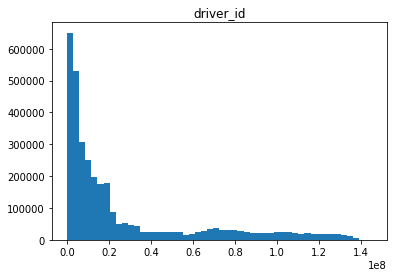

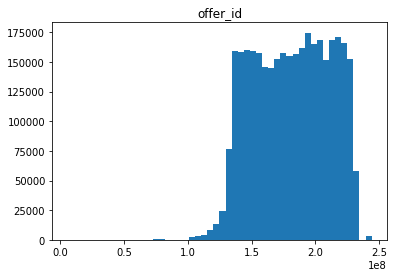

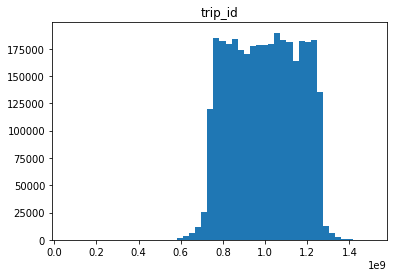

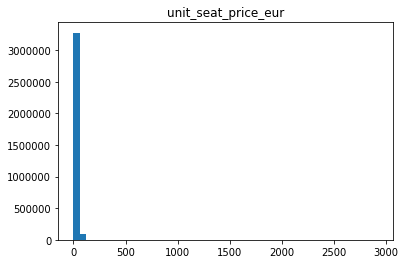

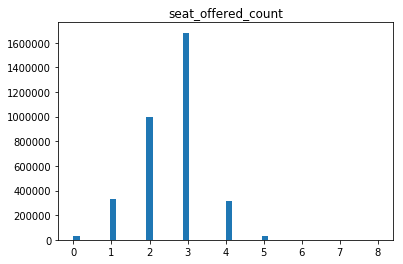

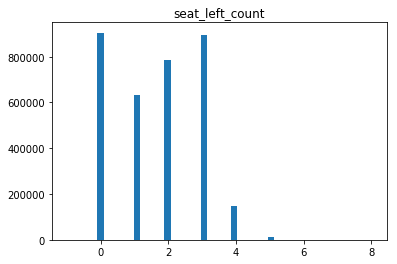

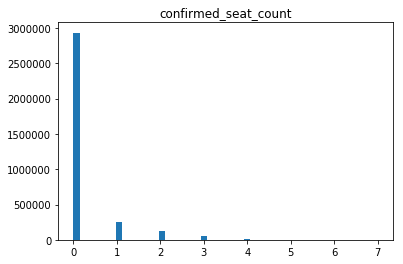

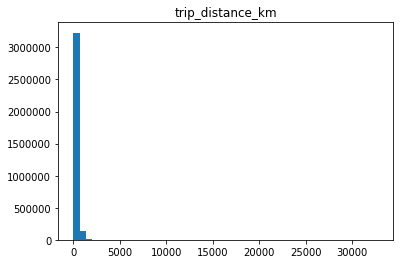

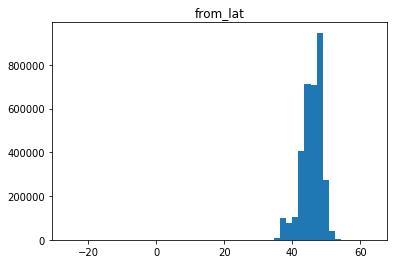

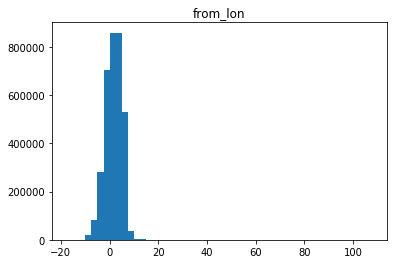

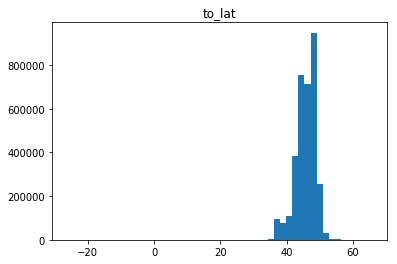

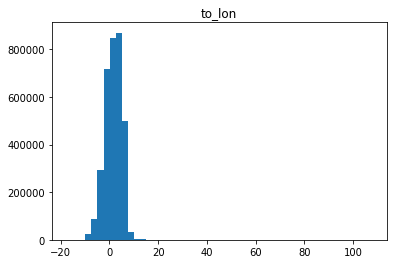

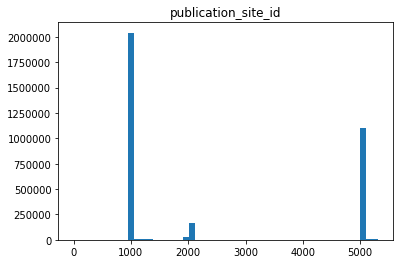

In [311]:
# histograms
for col in data.columns:
    if col in numerical_cols:
        fig, ax = plt.subplots()
        ax.hist(data[col], bins = 50)
        ax.set_title(col)

In [312]:
# seats count ok ?

In [313]:
(data['seat_left_count'] + data['confirmed_seat_count'] == data['seat_offered_count']).all()

False

In [314]:
(data['seat_left_count'] + data['confirmed_seat_count'] == data['seat_offered_count']).value_counts()

True     1970456
False    1409322
dtype: int64

In [315]:
data.shape

(3379778, 20)

### bools

In [316]:
for col in data.columns:
    if data[col].dtype == 'bool':
        print(data[col].value_counts())

False    2675381
True      704397
Name: is_main_trip, dtype: int64
False    3379778
Name: is_comfort, dtype: int64
False    1941009
True     1438769
Name: is_auto_accept_mode, dtype: int64


In [317]:
data.drop(columns='is_comfort', inplace = True)

### dates 

trip_date - min : 2015-04-15 00:00:00, max : 2015-10-12 22:50:00
published_date - min : 2012-05-02 00:00:00, max : 2015-09-07 00:00:00
signup_date - min : 2004-06-14 00:00:00, max : 2015-09-07 00:00:00


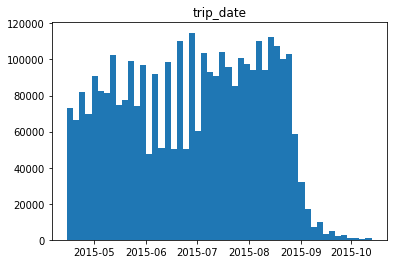

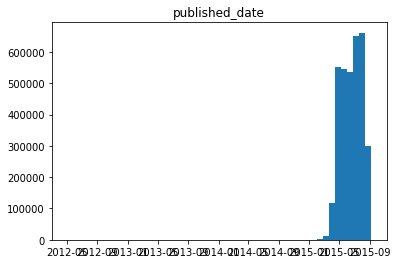

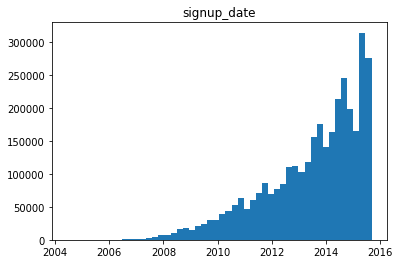

In [318]:
for name_col, col in data.select_dtypes(include=[np.datetime64]).items():
    print(f'{name_col} - min : {col.min()}, max : {col.max()}')
    fig, ax = plt.subplots()
    ax.hist(col, bins = 50)
    ax.set_title(name_col)

In [319]:
# removing outliers
crit = data['published_date'] > dt.datetime(2015,2,1)
data = data.loc[crit]

### strings

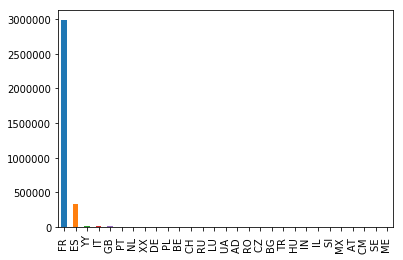

In [320]:
for name_col, col in data.items():
    if name_col in categorical_cols:
        col.value_counts().plot('bar')

## Reorder

In [321]:
data.sort_values(by='published_date', inplace=True)

In [322]:
data.shape

(3378337, 19)

# Train, val, test

In [323]:
# Setting these already here, because necessary for feature engineering (driver_appeal is only calculated on train set)
n_train = 1500000
n_val = 400000
n_test = 400000

# Feature engineering

## Y (= success)

In [324]:
data['y'] = data['confirmed_seat_count'] > 0

In [325]:
data['y'].value_counts()

False    2932189
True      446148
Name: y, dtype: int64

In [326]:
# no leaks
data.drop(columns='confirmed_seat_count', inplace=True)
data.drop(columns='seat_left_count', inplace=True)

In [327]:
data.columns

Index(['driver_id', 'offer_id', 'trip_id', 'trip_date', 'published_date',
       'signup_date', 'fixed_signup_country', 'is_main_trip',
       'unit_seat_price_eur', 'seat_offered_count', 'trip_distance_km',
       'from_lat', 'from_lon', 'to_lat', 'to_lon', 'is_auto_accept_mode',
       'publication_site_id', 'y'],
      dtype='object')

In [328]:
# seems useless
data.drop(columns = ['offer_id', 'trip_id'], inplace = True)


## dates

In [329]:
data.shape

(3378337, 16)

In [330]:
data.columns

Index(['driver_id', 'trip_date', 'published_date', 'signup_date',
       'fixed_signup_country', 'is_main_trip', 'unit_seat_price_eur',
       'seat_offered_count', 'trip_distance_km', 'from_lat', 'from_lon',
       'to_lat', 'to_lon', 'is_auto_accept_mode', 'publication_site_id', 'y'],
      dtype='object')

In [331]:
data['time_to_trip'] = (data['trip_date'] - data['published_date']).dt.days
data.drop(columns='published_date', inplace=True)

In [332]:
data['signup_to_trip']= (data['trip_date'] - data['signup_date']).dt.days
data.drop(columns='signup_date', inplace=True)

In [333]:
add_datepart(data, 'trip_date', time=True, drop=True)

In [334]:
data.drop(columns=['trip_Minute', 'trip_Second'], inplace=True)

In [335]:
data.head()

,driver_id,fixed_signup_country,is_main_trip,unit_seat_price_eur,seat_offered_count,trip_distance_km,from_lat,from_lon,to_lat,to_lon,is_auto_accept_mode,publication_site_id,y,time_to_trip,signup_to_trip,trip_Year,trip_Month,trip_Week,trip_Day,trip_Dayofweek,trip_Dayofyear,trip_Is_month_end,trip_Is_month_start,trip_Is_quarter_end,trip_Is_quarter_start,trip_Is_year_end,trip_Is_year_start,trip_Hour,trip_Elapsed
158739,51854111,FR,False,9.24,4,105,46.5802,0.340375,47.3941,0.68484,True,1000,False,79,80,2015,5,19,9,5,129,False,False,False,False,False,False,18,1431195900
3762,4047029,ES,True,79.20,3,861,43.2634,-2.934790,37.3891,-5.98446,False,1056,False,59,1011,2015,4,16,19,6,109,False,False,False,False,False,False,12,1429444800
643,8290801,FR,False,31.68,3,356,47.3941,0.684910,44.8378,-0.57918,False,1000,False,141,696,2015,7,28,10,4,191,False,False,False,False,False,False,16,1436546100
538326,5047677,FR,False,14.52,1,170,45.4597,9.176410,44.3067,8.47288,False,1000,False,87,905,2015,5,20,17,6,137,False,False,False,False,False,False,14,1431873000
538327,5047677,FR,False,26.40,1,317,45.4597,9.176410,43.6963,7.26570,False,1000,False,87,905,2015,5,20,17,6,137,False,False,False,False,False,False,14,1431873000


## bools

In [336]:
# bools to int
for col in data.columns: 
    if data[col].dtype == bool:
        data[col] = data[col].astype(int)

## driver_id to driver_appeal & driver_exp

In [337]:
driver_appeal = data.iloc[:n_train].groupby('driver_id').y.sum()/data.iloc[:n_train].groupby('driver_id').y.count()
driver_appeal = driver_appeal.reset_index()
driver_appeal.rename(columns={'y':'driver_appeal'},inplace=True)

In [338]:
driver_appeal_median = driver_appeal['driver_appeal'].median()

In [339]:
driver_appeal.head()

,driver_id,driver_appeal
0,267,1.000000
1,441,0.033333
2,587,0.285714
3,907,0.076923
4,925,1.000000


In [340]:
driver_exp = data.iloc[:n_train].groupby('driver_id').y.sum()
driver_exp = driver_exp.reset_index()
driver_exp.rename(columns={'y':'driver_exp'}, inplace=True)

In [341]:
driver_exp_median = driver_exp['driver_exp'].median()

In [342]:
driver_exp.head()

,driver_id,driver_exp
0,267,1
1,441,1
2,587,2
3,907,1
4,925,1


In [343]:
data = data.merge(driver_appeal, how='left', on='driver_id')

In [344]:
crit = data['driver_appeal'].isnull()
data.loc[crit,'driver_appeal'] = driver_appeal_median

In [345]:
data = data.merge(driver_exp, how='left', on='driver_id')

In [346]:
crit = data['driver_exp'].isnull()
data.loc[crit,'driver_exp'] = driver_exp_median

In [347]:
data.drop(columns='driver_id', inplace=True)

In [348]:
data.head()

,fixed_signup_country,is_main_trip,unit_seat_price_eur,seat_offered_count,trip_distance_km,from_lat,from_lon,to_lat,to_lon,is_auto_accept_mode,publication_site_id,y,time_to_trip,signup_to_trip,trip_Year,trip_Month,trip_Week,trip_Day,trip_Dayofweek,trip_Dayofyear,trip_Is_month_end,trip_Is_month_start,trip_Is_quarter_end,trip_Is_quarter_start,trip_Is_year_end,trip_Is_year_start,trip_Hour,trip_Elapsed,driver_appeal,driver_exp
0,FR,0,9.24,4,105,46.5802,0.340375,47.3941,0.68484,1,1000,0,79,80,2015,5,19,9,5,129,0,0,0,0,0,0,18,1431195900,0.010989,1.0
1,ES,1,79.20,3,861,43.2634,-2.934790,37.3891,-5.98446,0,1056,0,59,1011,2015,4,16,19,6,109,0,0,0,0,0,0,12,1429444800,0.000000,0.0
2,FR,0,31.68,3,356,47.3941,0.684910,44.8378,-0.57918,0,1000,0,141,696,2015,7,28,10,4,191,0,0,0,0,0,0,16,1436546100,0.000000,0.0
3,FR,0,14.52,1,170,45.4597,9.176410,44.3067,8.47288,0,1000,0,87,905,2015,5,20,17,6,137,0,0,0,0,0,0,14,1431873000,0.166667,1.0
4,FR,0,26.40,1,317,45.4597,9.176410,43.6963,7.26570,0,1000,0,87,905,2015,5,20,17,6,137,0,0,0,0,0,0,14,1431873000,0.166667,1.0


## Lat, lon to trip_appeal 

In [349]:
coords = pd.DataFrame()
coords['lat'] =  data.iloc[:n_train]['from_lat']
coords['lon'] =  data.iloc[:n_train]['from_lon']

In [350]:
coords.head()

,lat,lon
0,46.5802,0.340375
1,43.2634,-2.934790
2,47.3941,0.684910
3,45.4597,9.176410
4,45.4597,9.176410


[[45.48160812  4.9483945 ]
 [45.96724664 -0.93095671]
 [42.76853933 -3.4143691 ]
 [50.38575231  3.19219278]
 [43.43092582 -0.09438833]
 [47.36955397  2.05832226]
 [48.29049139  7.5685155 ]
 [37.43263333 -4.06552344]
 [43.68527231  3.96262201]
 [49.07881787 -0.2936126 ]
 [38.00615687 -1.34669961]
 [50.3617205   2.01281739]
 [43.73851435  1.33460995]
 [48.36286602 -4.07827005]
 [46.36639309  0.10069829]
 [43.69111101  6.87895096]
 [42.50627183 -8.14313141]
 [43.56436667  5.58205109]
 [48.34986816 -1.6442849 ]
 [48.59560175  4.10559152]
 [47.50078903 -0.59463274]
 [44.37146605  2.67725395]
 [52.13006061 -1.03195405]
 [45.96283115  3.21007838]
 [52.60352    11.255927  ]
 [44.80277704 -0.47518245]
 [43.04508213  2.82368659]
 [46.92475481  4.87300196]
 [49.00634957  6.16681731]
 [39.15544409 -6.71598204]
 [40.15354877 -3.65002951]
 [48.01667064 -2.91641164]
 [45.9022476   6.22522422]
 [45.53319231  1.3783658 ]
 [45.4251225  10.2056125 ]
 [43.49711878 -1.41114042]
 [47.65256768  0.60830483]
 

(20, 57.710239690495555)

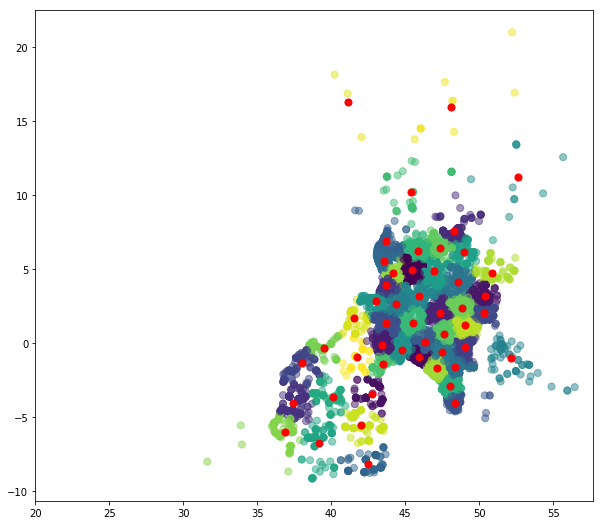

In [351]:
coords_sample = coords.sample(frac=0.01)
kmeans = KMeans(n_clusters=50).fit(coords_sample)
centroids = kmeans.cluster_centers_
print(centroids)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(coords_sample['lat'], coords_sample['lon'], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
ax.set_aspect('equal')
ax.set_xlim(left=20)

In [352]:
regions = pd.DataFrame()
regions[['lat','lon']] = pd.DataFrame(centroids)
regions.reset_index(inplace = True)
regions.rename(columns={'index':'region_id'}, inplace=True)

In [353]:
regions.head()

,region_id,lat,lon
0,0,45.481608,4.948395
1,1,45.967247,-0.930957
2,2,42.768539,-3.414369
3,3,50.385752,3.192193
4,4,43.430926,-0.094388


In [355]:
def map_to_region_id(lat,lon,regions):
    distances = ((regions['lat'].values.reshape((1,-1)) - lat.values.reshape((-1,1)))**2 
                    + (regions['lon'].values.reshape((1,-1)) - lon.values.reshape(-1,1))**2 )
    return np.argmin(distances, axis=1).tolist()

In [356]:
data['from_region_id'] = map_to_region_id(data['from_lat'], data['from_lon'], regions)
data['to_region_id'] = map_to_region_id(data['to_lat'], data['to_lon'], regions)

In [357]:
data.drop(columns=['from_lat','from_lon','to_lat','to_lon'], inplace=True)

In [358]:
data['trip_r_to_r'] = list(zip(data['from_region_id'].values.tolist(), data['to_region_id'].values.tolist()))

In [359]:
data['trip_r_to_r'].nunique()

2406

In [360]:
trip_appeal = data.iloc[:n_train].groupby('trip_r_to_r').y.sum() / data.iloc[:n_train].groupby('trip_r_to_r').y.count()
trip_appeal = trip_appeal.reset_index()
trip_appeal.rename(columns={'y':'trip_appeal'}, inplace=True)

In [361]:
trip_appeal_median = trip_appeal['trip_appeal'].median()

In [362]:
trip_appeal.head()

,trip_r_to_r,trip_appeal
0,"(0, 0)",0.092685
1,"(0, 1)",0.304348
2,"(0, 2)",0.000000
3,"(0, 3)",0.258780
4,"(0, 4)",0.109195


In [363]:
data = data.merge(trip_appeal, on='trip_r_to_r', how='left')

In [364]:
crit = data['trip_appeal'].isnull()
data.loc[crit,'trip_appeal'] = trip_appeal_median

In [365]:
data.drop(columns=['from_region_id', 'to_region_id', 'trip_r_to_r'], inplace=True)

In [366]:
data.head()

,fixed_signup_country,is_main_trip,unit_seat_price_eur,seat_offered_count,trip_distance_km,is_auto_accept_mode,publication_site_id,y,time_to_trip,signup_to_trip,trip_Year,trip_Month,trip_Week,trip_Day,trip_Dayofweek,trip_Dayofyear,trip_Is_month_end,trip_Is_month_start,trip_Is_quarter_end,trip_Is_quarter_start,trip_Is_year_end,trip_Is_year_start,trip_Hour,trip_Elapsed,driver_appeal,driver_exp,trip_appeal
0,FR,0,9.24,4,105,1,1000,0,79,80,2015,5,19,9,5,129,0,0,0,0,0,0,18,1431195900,0.010989,1.0,0.086599
1,ES,1,79.20,3,861,0,1056,0,59,1011,2015,4,16,19,6,109,0,0,0,0,0,0,12,1429444800,0.000000,0.0,0.072581
2,FR,0,31.68,3,356,0,1000,0,141,696,2015,7,28,10,4,191,0,0,0,0,0,0,16,1436546100,0.000000,0.0,0.128401
3,FR,0,14.52,1,170,0,1000,0,87,905,2015,5,20,17,6,137,0,0,0,0,0,0,14,1431873000,0.166667,1.0,0.102970
4,FR,0,26.40,1,317,0,1000,0,87,905,2015,5,20,17,6,137,0,0,0,0,0,0,14,1431873000,0.166667,1.0,0.102970


## marginal price : km/eur

In [367]:
data['eur/km'] = data['unit_seat_price_eur'] / data['trip_distance_km']

In [368]:
data.loc[data['eur/km'].isnull(), 'eur/km'] = data['eur/km'].median()

In [369]:
data.loc[data['eur/km']==np.Infinity, 'eur/km'] = data.loc[~(data['eur/km']==np.Infinity), 'eur/km'].max()

In [370]:
data.columns

Index(['fixed_signup_country', 'is_main_trip', 'unit_seat_price_eur',
       'seat_offered_count', 'trip_distance_km', 'is_auto_accept_mode',
       'publication_site_id', 'y', 'time_to_trip', 'signup_to_trip',
       'trip_Year', 'trip_Month', 'trip_Week', 'trip_Day', 'trip_Dayofweek',
       'trip_Dayofyear', 'trip_Is_month_end', 'trip_Is_month_start',
       'trip_Is_quarter_end', 'trip_Is_quarter_start', 'trip_Is_year_end',
       'trip_Is_year_start', 'trip_Hour', 'trip_Elapsed', 'driver_appeal',
       'driver_exp', 'trip_appeal', 'eur/km'],
      dtype='object')

## Categories to codes

In [371]:
## pass to cats : fixed_signup_country, publication_site_id
data['publication_site_id'] = data['publication_site_id'].astype(str)

In [372]:
# strings to cats
for col_name,col in data.items():
    if is_string_dtype(col): data[col_name] = col.astype('category').cat.as_ordered()

In [373]:
for col_name,col in data.items():
    if col.dtype.name == 'category': data[col_name] = col.cat.codes

In [374]:
data.head()

,fixed_signup_country,is_main_trip,unit_seat_price_eur,seat_offered_count,trip_distance_km,is_auto_accept_mode,publication_site_id,y,time_to_trip,signup_to_trip,trip_Year,trip_Month,trip_Week,trip_Day,trip_Dayofweek,trip_Dayofyear,trip_Is_month_end,trip_Is_month_start,trip_Is_quarter_end,trip_Is_quarter_start,trip_Is_year_end,trip_Is_year_start,trip_Hour,trip_Elapsed,driver_appeal,driver_exp,trip_appeal,eur/km
0,9,0,9.24,4,105,1,0,0,79,80,2015,5,19,9,5,129,0,0,0,0,0,0,18,1431195900,0.010989,1.0,0.086599,0.088000
1,8,1,79.20,3,861,0,1,0,59,1011,2015,4,16,19,6,109,0,0,0,0,0,0,12,1429444800,0.000000,0.0,0.072581,0.091986
2,9,0,31.68,3,356,0,0,0,141,696,2015,7,28,10,4,191,0,0,0,0,0,0,16,1436546100,0.000000,0.0,0.128401,0.088989
3,9,0,14.52,1,170,0,0,0,87,905,2015,5,20,17,6,137,0,0,0,0,0,0,14,1431873000,0.166667,1.0,0.102970,0.085412
4,9,0,26.40,1,317,0,0,0,87,905,2015,5,20,17,6,137,0,0,0,0,0,0,14,1431873000,0.166667,1.0,0.102970,0.083281


## Save

In [375]:
data.to_pickle('data3.pkl')

In [376]:
#data = pd.read_pickle('data.pkl')

# Impact of parameters on success

In [377]:
for col_name, col in data.items():
    print(f'{col_name}:{col.dtype}')

fixed_signup_country:int8
is_main_trip:int32
unit_seat_price_eur:float64
seat_offered_count:int64
trip_distance_km:int64
is_auto_accept_mode:int32
publication_site_id:int8
y:int32
time_to_trip:int64
signup_to_trip:int64
trip_Year:int64
trip_Month:int64
trip_Week:int64
trip_Day:int64
trip_Dayofweek:int64
trip_Dayofyear:int64
trip_Is_month_end:int32
trip_Is_month_start:int32
trip_Is_quarter_end:int32
trip_Is_quarter_start:int32
trip_Is_year_end:int32
trip_Is_year_start:int32
trip_Hour:int64
trip_Elapsed:int64
driver_appeal:float64
driver_exp:float64
trip_appeal:float64
eur/km:float64


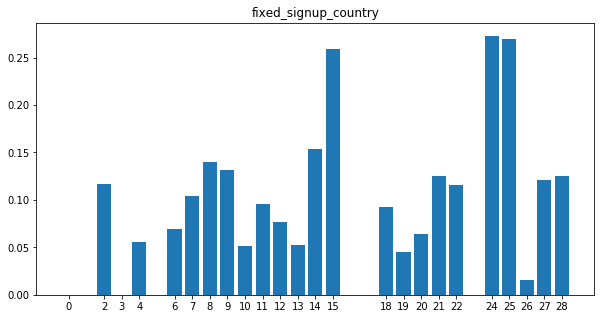

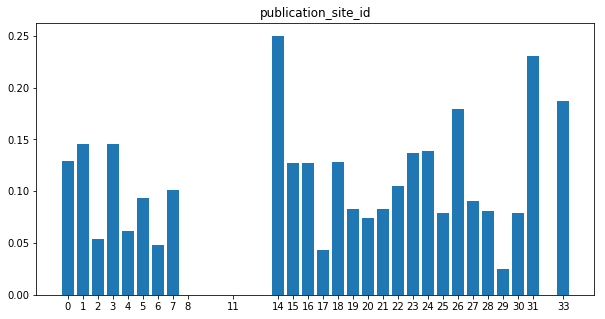

In [378]:
# parameters impact - int8
for col_name, col in data.select_dtypes(include=[np.int8]).items():
    param_impact = data.groupby(col_name).y.sum()/data.groupby(col_name).y.count()
    param_impact = param_impact.loc[data.groupby(col_name).y.count()>10]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(param_impact.index, param_impact.values)
    ax.set_xticks(param_impact.index)
    ax.set_title(col_name)

In [379]:
# Reordering these two above (to make better splits for RandomForest) - based only on what is visible in train to prevent leaks)
for col_name, col in data.select_dtypes(include=[np.int8]).items():
    param_impact = data.iloc[:n_train].groupby(col_name).y.sum()/data.iloc[:n_train].groupby(col_name).y.count()
    crit = ~(data.iloc[:n_train].groupby(col_name).y.count()>10)
    param_impact.loc[crit] = param_impact.loc[~crit].median()
    index_to_add = list(set(data[col_name].unique().tolist())-set(param_impact.index.tolist()))
    param_impact_to_add = pd.Series([param_impact.loc[~crit].median() for _ in range(len(index_to_add))],index=index_to_add)
    param_impact = param_impact.append(param_impact_to_add)
    map_idx = param_impact.sort_values().reset_index().reset_index().set_index('index').sort_index()['level_0'].tolist()
    data[col_name] = np.array([map_idx[p_id] for p_id in data[col_name].values.tolist()]).astype(np.int8)

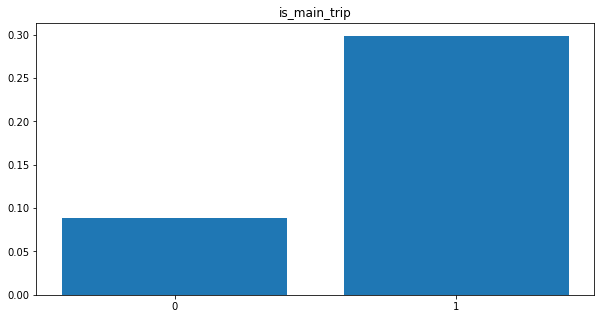

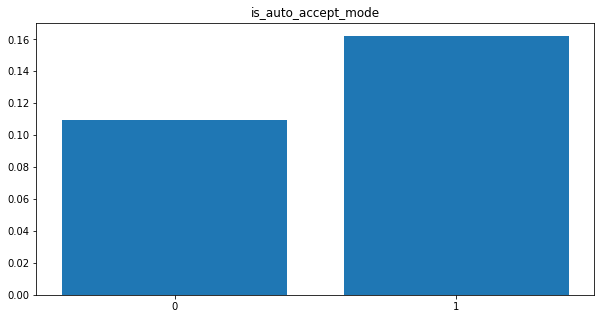

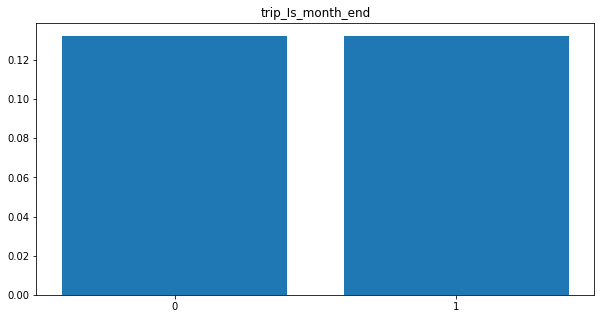

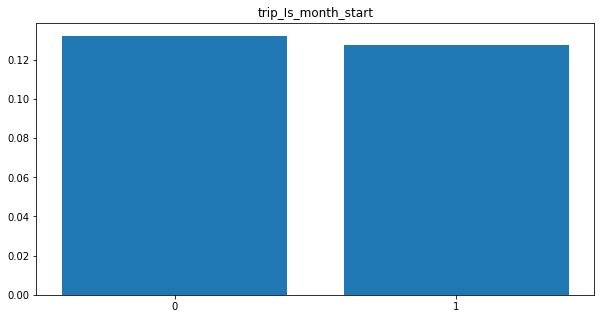

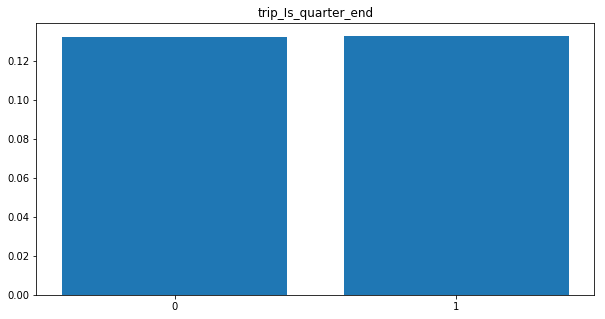

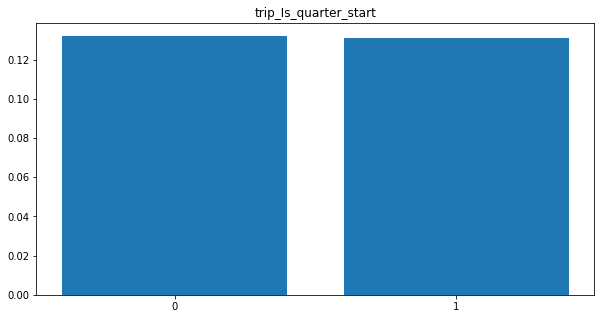

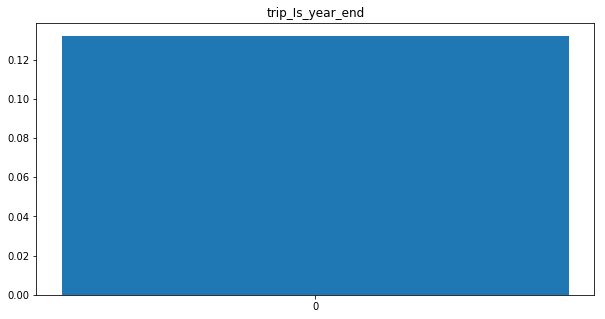

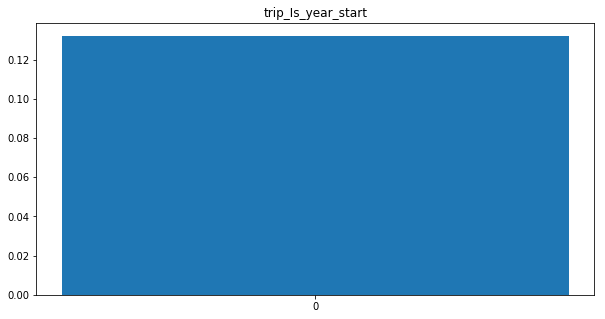

In [380]:
# parameters impact - int32
for col_name, col in data.select_dtypes(include=[np.int32]).drop(columns='y').items():
    param_impact = data.groupby(col_name).y.sum()/data.groupby(col_name).y.count()
    param_impact = param_impact.loc[data.groupby(col_name).y.count()>10]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(param_impact.index, param_impact.values)
    ax.set_xticks(param_impact.index)
    ax.set_title(col_name)

In [381]:
data.drop(columns=['trip_Is_year_end', 'trip_Is_year_start', 'trip_Year'], inplace=True)

In [382]:
## is_main_trip >> is_auto_accept_mode


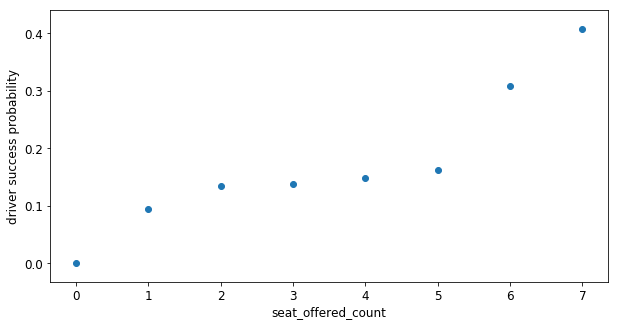

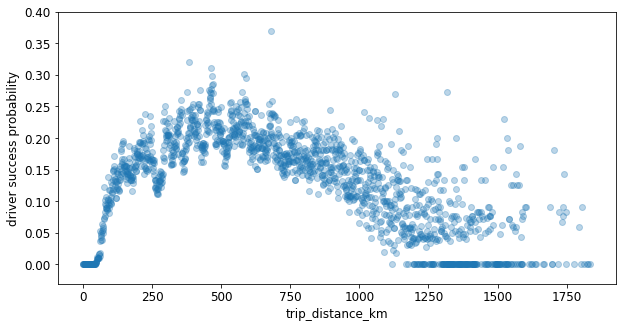

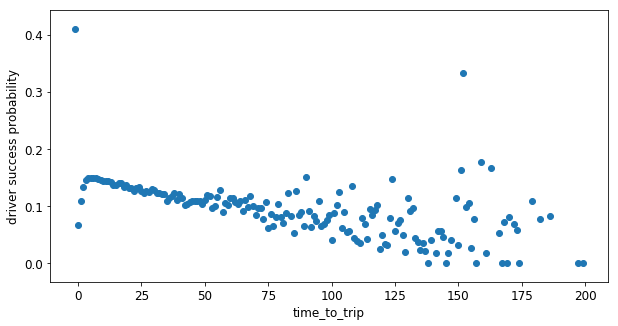

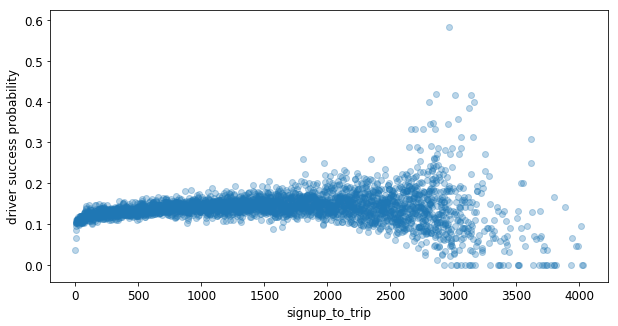

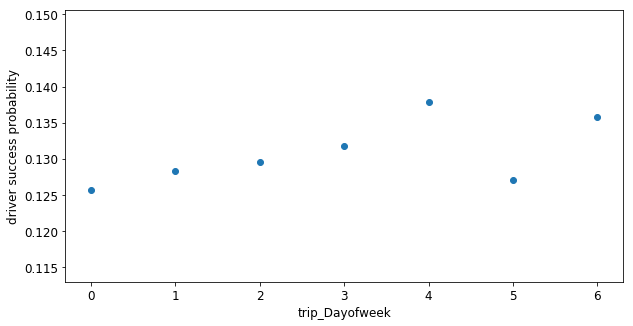

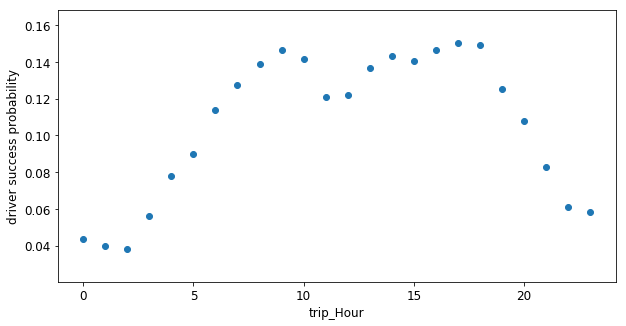

In [414]:
# parameters impact - int64
for col_name, col in data.select_dtypes(include=[np.int64]).drop(columns='trip_Elapsed').items():
    param_impact = data.groupby(col_name).y.sum()/data.groupby(col_name).y.count()
    param_impact = param_impact.loc[data.groupby(col_name).y.count()>10]
    alpha = 1 if len(param_impact.index) < 300 else 0.3
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(param_impact.index, param_impact.values, alpha = alpha)
    ax.set_xlabel(col_name, fontsize=fontsize)
    ax.set_ylabel('driver success probability',fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)

Text(0.5, 1.0, 'trip_Elapsed')

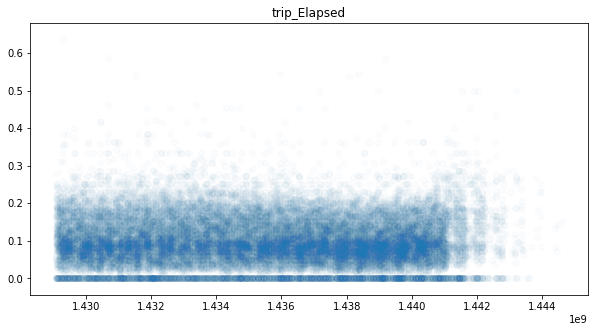

In [384]:
col_name = 'trip_Elapsed'
param_impact = data.groupby(col_name).y.sum()/data.groupby(col_name).y.count()
param_impact = param_impact.loc[data.groupby(col_name).y.count()>10]
alpha = 1 if len(param_impact.index) < 300 else 0.02
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(param_impact.index, param_impact.values, alpha = alpha)
ax.set_title(col_name)

In [385]:
data.drop(columns=['trip_Day','trip_Month','trip_Dayofyear', 'trip_Week', 'trip_Elapsed'], inplace=True)

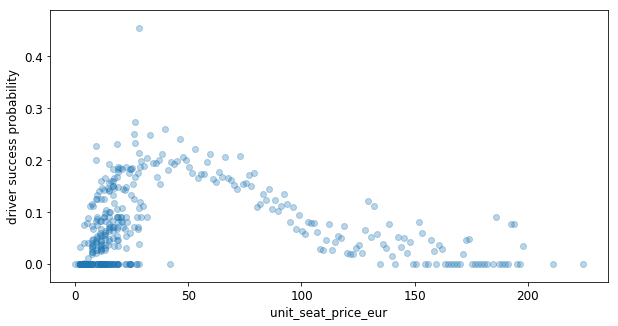

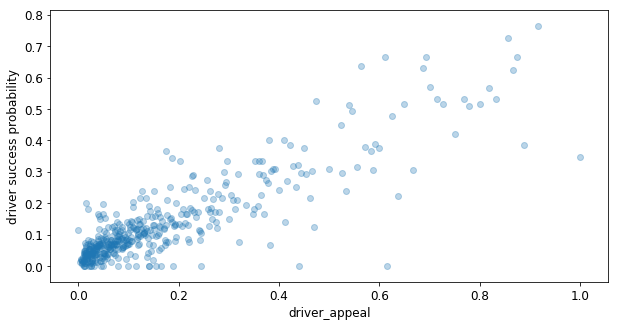

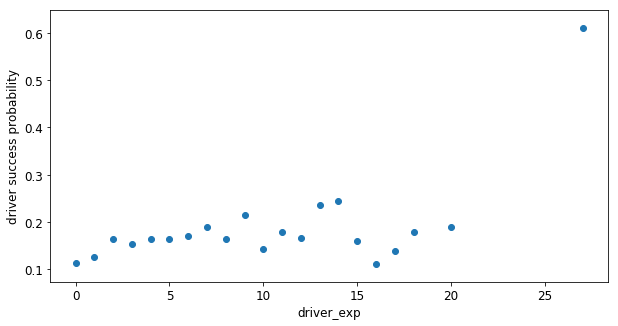

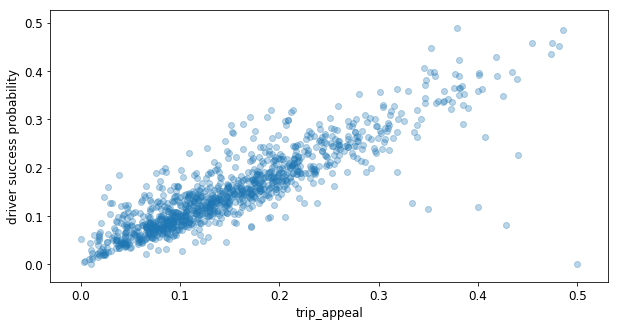

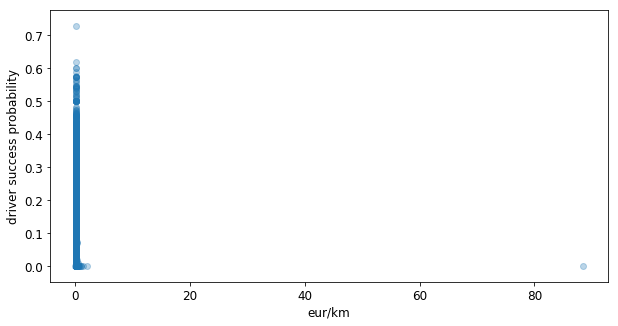

In [386]:
# parameters impact - float64
for col_name, col in data.select_dtypes(include=[np.float64]).items():
    param_impact = data.iloc[n_train:].groupby(col_name).y.sum()/data.iloc[n_train:].groupby(col_name).y.count()
    param_impact = param_impact.loc[data.iloc[n_train:].groupby(col_name).y.count()>10]
    alpha = 1 if len(param_impact.index) < 300 else 0.3
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(param_impact.index, param_impact.values, alpha = alpha)
    ax.set_xlabel(col_name, fontsize=fontsize)
    ax.set_ylabel('driver success probability', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)

Text(0, 0.5, 'driver succes probability')

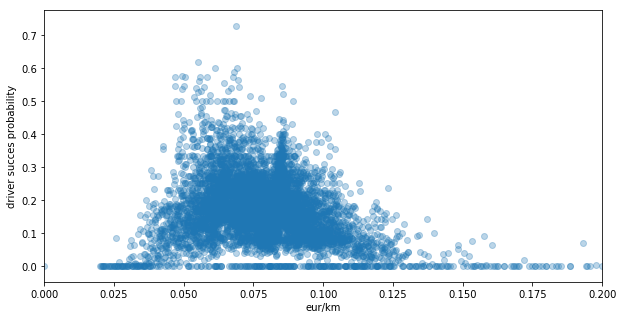

In [410]:
# zoom on marginal price impact
col_name = 'eur/km'
param_impact = data.iloc[n_train:].groupby(col_name).y.sum()/data.iloc[n_train:].groupby(col_name).y.count()
param_impact = param_impact.loc[data.iloc[n_train:].groupby(col_name).y.count()>10]
alpha = 1 if len(param_impact.index) < 300 else 0.3
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(param_impact.index, param_impact.values, alpha = alpha)
ax.set_xlim(left=0,right=0.2)
ax.set_xlabel(col_name)
ax.set_ylabel('driver succes probability')

# Model

In [388]:
data_train = data.iloc[:n_train]
data_val = data.iloc[n_train:(n_train+n_val)]
data_test = data.iloc[(n_train+n_val):(n_train+n_val+n_test)]
print(f'n_train:{n_train}, n_val:{n_val}, n_test:{n_test}')

n_train:1500000, n_val:400000, n_test:400000


In [389]:
X_train, y_train = data_train.drop(columns='y'), data_train['y']
X_val, y_val = data_val.drop(columns='y'), data_val['y']
X_test, y_test = data_test.drop(columns='y'), data_test['y']

In [390]:
def print_score(m, subset_cols):
    pred_train = m.predict_proba(X_train.loc[:, subset_cols])
    pred_val = m.predict_proba(X_val.loc[:, subset_cols])
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, pred_train[:,1])
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, pred_val[:,1])
    res = [metrics.auc(fpr_train, tpr_train), metrics.auc(fpr_val, tpr_val),
                m.score(X_train.loc[:,subset_cols], y_train), m.score(X_val.loc[:,subset_cols], y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [391]:
def print_score_NB(m1,m2):
    #pred_train = m.predict_proba(X_train)
    prob_val_1 = m1.predict_proba(X_val.loc[:,continuous_cols])[:,1]
    prob_val_2 = m2.predict_proba(X_val.loc[:,categorical_cols])[:,1]
    prob_val = prob_val_1 * prob_val_2
   # fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, pred_train[:,1])
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(y_val, prob_val)
    res = [metrics.auc(fpr_val, tpr_val)]
    print(res)

In [392]:
categorical_cols = ['fixed_signup_country', 'is_main_trip', 
         'is_auto_accept_mode', 'publication_site_id', 'trip_Is_month_end', 'trip_Is_month_start',
       'trip_Is_quarter_end', 'trip_Is_quarter_start', 'trip_Hour']

In [393]:
continuous_cols = ['unit_seat_price_eur','seat_offered_count','trip_distance_km','time_to_trip', 
                  'signup_to_trip','driver_appeal', 'driver_exp', 'trip_appeal','eur/km']

## Logistic regression

In [394]:
m = LogisticRegression()
m.fit(X_train.loc[:,continuous_cols], y_train)

C:\Users\thomas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [395]:
%%time
print_score(m, continuous_cols)

[0.8991405476148704, 0.7047644276461507, 0.904396, 0.85805]
Wall time: 4.77 s


## Random Forest

In [396]:
set_rf_samples(50000)

In [397]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=5)
m.fit(X_train, y_train)
m.score(X_train,y_train)

0.909444

In [398]:
%%time
print_score(m, X_train.columns)

[0.9278839163986814, 0.7263983767620242, 0.909444, 0.862895]
Wall time: 27.1 s


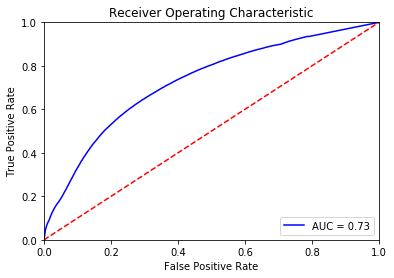

In [399]:
probs = m.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [400]:
rf_feat_importance(m, X_train)

,cols,imp
15,driver_appeal,0.424125
16,driver_exp,0.107213
17,trip_appeal,0.086983
4,trip_distance_km,0.066123
1,is_main_trip,0.059143
2,unit_seat_price_eur,0.052799
18,eur/km,0.047194
8,signup_to_trip,0.045794
7,time_to_trip,0.031168
14,trip_Hour,0.028319


## Naive Bayes

In [401]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [402]:
X_train.columns

Index(['fixed_signup_country', 'is_main_trip', 'unit_seat_price_eur',
       'seat_offered_count', 'trip_distance_km', 'is_auto_accept_mode',
       'publication_site_id', 'time_to_trip', 'signup_to_trip',
       'trip_Dayofweek', 'trip_Is_month_end', 'trip_Is_month_start',
       'trip_Is_quarter_end', 'trip_Is_quarter_start', 'trip_Hour',
       'driver_appeal', 'driver_exp', 'trip_appeal', 'eur/km'],
      dtype='object')

In [403]:
m1 = GaussianNB()
m2 = MultinomialNB()

In [404]:
m1.fit(X_train.loc[:,continuous_cols], y_train)
m2.fit(X_train.loc[:,categorical_cols], y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [405]:
%%time
print_score_NB(m1,m2)

[0.7601737466553424]
Wall time: 2 s


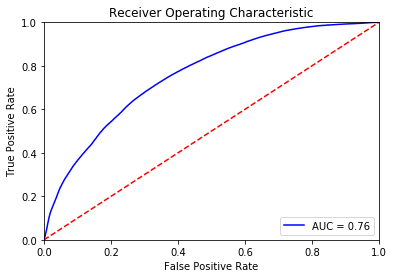

In [406]:
probs = (m1.predict_proba(X_val.loc[:,continuous_cols])[:,1]) * (m2.predict_proba(X_val.loc[:,categorical_cols])[:,1]) 
fpr, tpr, threshold = metrics.roc_curve(y_val, probs)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [407]:
computing_time = [2.0,2.5,14]
auc = [0.76, 0.71, 0.73]
models = ['NB', 'LR', 'RF']

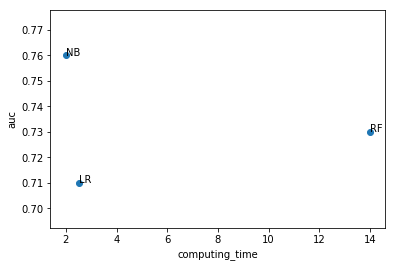

In [408]:
fig, ax = plt.subplots()
ax.scatter(computing_time, auc)
ax.set_xlabel('computing_time')
ax.set_ylabel('auc')
for i, txt in enumerate(models):
    ax.annotate(txt, (computing_time[i], auc[i]))